## Data Reading

First, we are just going to read the information of the paleamagnetic poles. This notebook creates proccessed versions of the PP and VGPs data in a python-friendly format. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scripts.auxiliar import get_files_in_directory, spherical2cartesian

We first define the current path we are currently working on and define the directories of the data files with respect to it. 

In [2]:
current_path = os.getcwd() 
data_path_PP = current_path + "/data/poles_NAM"
file_name = "/NAM_poles_0_130_Myr.xlsx"

In [3]:
df_NAM = pd.read_excel(data_path_PP + file_name)
df_NAM

,name,min_age,max_age,age,slat,slon,N,k,alpha95,dp,...,lithology,Rlat,Rlon,Euler_lat,Euler_lon,Euler_ang,author,Q,reliability,age constraints
0,USGS SW North America composite,0.0,1.0,0.5,36.30,242.13,38,24.7,4.8,NaN,...,volcanic,-86.3,5.7,0.0,0.0,0.0,Mankinen (2008),5,NaN,Brunhes normal chron
1,Michoacan Guanajuato volcanic ﬁeld,0.0,0.6,0.3,19.25,257.67,8,29.0,9.1,8.5,...,volcanic,-86.4,9.2,79.2,23.0,0.2,Maciel Peña et al. (2009),5,NaN,Ar-Ar ages of 82 to 612 ka (from another study)
2,Tequila volcanic ﬁelds,0.1,1.1,0.6,20.46,256.76,17,26.0,7.1,6.9,...,volcanic,-85.3,-94.1,79.9,22.7,0.3,Ceja et al. (2006),5,NaN,Ar/Ar ages of 0.115 to 1.13 Ma (from another s...
3,Trans Mexican Volcanic Belt,0.0,2.0,1.0,19.40,260.10,24,47.3,4.3,3.5,...,volcanic,-88.9,-75.1,79.9,22.7,0.3,Ruiz-Martínez et al. (2010),5,NaN,all Quaternary rocks (some K-Ar dated)
4,Katherine Creek sediments,0.0,3.0,1.5,65.00,232.40,100,9.1,4.9,7.9,...,clastics,-80.0,4.2,80.8,22.8,0.4,Barendregt et al. (1996),3,NaN,magnetostratigraphy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Tatnic Complex,120.0,124.0,122.0,43.30,289.30,10,113.0,4.6,NaN,...,plutonic,-44.4,86.2,65.7,-19.8,55.3,McEnroe (1996b),5,"high-T CHRM, exsolution lamellae and fine reac...","122±2; K-Ar on biotite in gabbro, Ar-Ar on bio..."
61,Monteregian Hills intrusives,117.0,127.0,122.0,45.30,286.80,70,49.2,2.4,2.8,...,plutonic,-51.7,79.7,65.7,-19.8,55.3,Foster and Symons (1979),6,NaN,118±4 Ma Rb-Sr; 123±4 K-Ar
62,White Mountains igneous complex,119.0,126.0,122.5,43.50,288.30,8,274.9,3.3,4.2,...,plutonic,-51.5,77.6,65.7,-19.8,55.3,Van Fossen and Kent (1992),5,NaN,Ar/Ar age of 122.5±3.5
63,Lebanon diorite,122.0,128.0,125.0,43.40,289.20,5,113.0,7.5,NaN,...,plutonic,-49.4,83.7,65.4,-18.9,56.8,McEnroe (1996b),5,"high-T CHRM, exsolution lamellae and fine reac...",125±3 Ma K-Ar on biotite. They discarded disco...


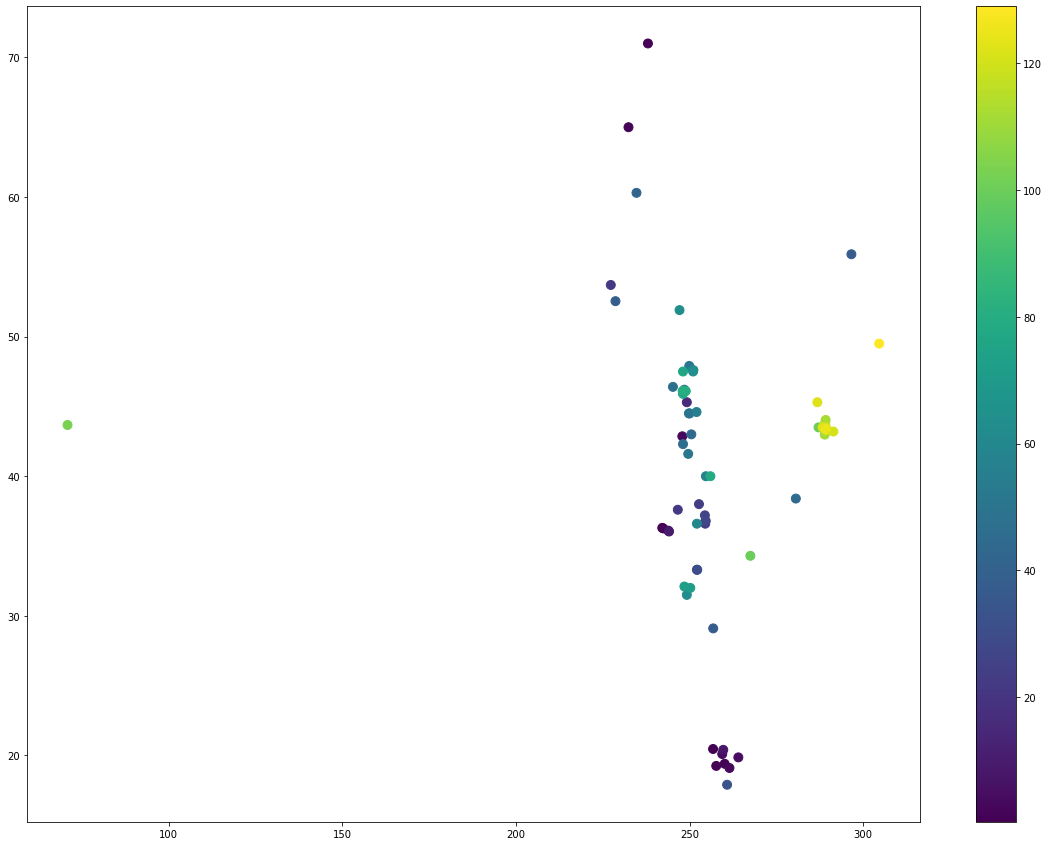

In [4]:
plt.figure(figsize=(20,15))
plt.scatter(df_NAM.slon, df_NAM.slat, c=df_NAM.age, s=80)
plt.colorbar()

In [5]:
df_NAM["x"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[0], axis=1)
df_NAM["y"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[1], axis=1)
df_NAM["z"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[2], axis=1)

We make a few simple plots of the PPs

In [6]:
import plotly
import plotly.graph_objects as go

In [23]:
PPs_plot = go.Scatter3d(x=df_NAM.x.values, y=df_NAM.y.values, z=df_NAM.z.values, mode="markers", 
                            marker=go.scatter3d.Marker(color="black", opacity=1.0, size=3, symbol="circle"),
                            showlegend=False) 

In [24]:
noaxis=dict(showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            ticks='',
            title='',
            zeroline=False)

layout = go.Layout(title="Paleomagnetic Poles for the North America plate",
                    scene = dict(
                    xaxis = noaxis,
                    yaxis = noaxis,
                    zaxis = noaxis,
                    camera=dict(eye=dict(x=-1.5, y=0, z=0.2))))

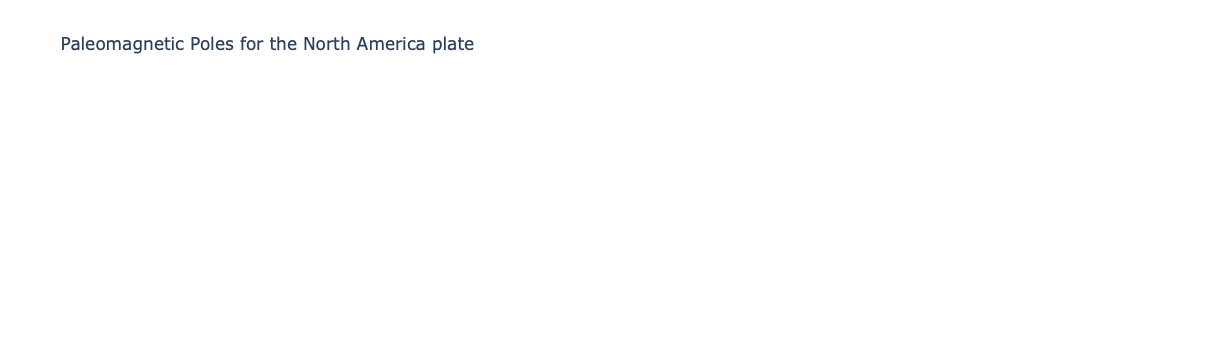

In [27]:
fig = go.Figure([PPs_plot], layout=layout)
fig.show()

### Reading the Virtual Geoomagnetic Poles (VGP)

In [11]:
data_path_VGP = current_path + "/data/VGP_NAM"

# this reads the names of all the files in the data path foldel we have
files_names = get_files_in_directory(data_path_VGP)

In [12]:
for fname in files_names:
    
    # do something...

['/Users/facundosapienza/Dropbox/CEED/Young_CEED_2.0/data/VGP_NAM/NAM_poles_0_130.csv']